# Libraries and Initialization

In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
import xgboost as xgb

# Matplotlib Deafault Parameters
pylab.rcParams['figure.figsize'] = (12, 7)
pylab.rcParams['axes.titlesize'] = 18.0
pylab.rcParams['xtick.labelsize'] = 16.0
pylab.rcParams['ytick.labelsize'] = 16.0
pylab.rcParams['legend.fontsize'] = 14.0
pylab.rcParams['axes.labelsize'] = 17.0

# Loading the Data 

In [10]:
df = pd.read_csv("data/DataCoSupplyChainDataset.csv", encoding="iso-8859-1")

In [12]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [14]:
df.shape

(180519, 53)

# Finding the dataset key 

Is the Order ID unique?

In [23]:
df["Order Id"].nunique()

65752

The Order ID is not unique.

In [25]:
df["Order Id"].value_counts().head(5)

30397    5
16203    5
42806    5
49302    5
60278    5
Name: Order Id, dtype: int64

But the key `Order Id` and `Order Item Id` is.

In [34]:
df["Order Item Id"].value_counts().head(5)

2047      1
79372     1
144748    1
134507    1
132458    1
Name: Order Item Id, dtype: int64

In [45]:
df[df["Order Id"] == 30397][["Product Card Id", "Product Name", "Customer Fname", "Customer Lname", "Order Item Id", "Days for shipping (real)", "Customer Country"]]

,Product Card Id,Product Name,Customer Fname,Customer Lname,Order Item Id,Days for shipping (real),Customer Country
110283,957,Diamondback Women's Serene Classic Comfort Bi,Mary,Smith,75980,2,EE. UU.
116649,116,Nike Men's Comfort 2 Slide,Mary,Smith,75981,2,EE. UU.
116650,191,Nike Men's Free 5.0+ Running Shoe,Mary,Smith,75983,2,EE. UU.
153559,1004,Field & Stream Sportsman 16 Gun Fire Safe,Mary,Smith,75984,2,EE. UU.
153560,1004,Field & Stream Sportsman 16 Gun Fire Safe,Mary,Smith,75982,2,EE. UU.


Given that there is no information regarding the shipment ID, I am assuming that each order (even with multiples products) generates a shipment.

# Group the dataframe by order

In [329]:
print(df["Delivery Status"].isna().sum())
print(df["Order Country"].isna().sum())
print(df["Customer Zipcode"].isna().sum())
print(df["Order Id"].isna().sum())

0
0
0
0


In [501]:
df = df.drop(df[df["Customer Zipcode"].isna()].index)

In [502]:
df.shape

(180516, 53)

We discard rows that do not present any value in the `Customer Zipcode` feature.

In [504]:
# define mode aggregation function
def mode(x):
    return x.value_counts().index[0]
mode.__name__ = "mode"

categorical_features = [
    "Order Id", "Customer Country", "Shipping Mode", 
    "Days for shipping (real)", "Days for shipment (scheduled)",
    "order date (DateOrders)", "shipping date (DateOrders)",
    "Delivery Status", "Order Country", "Customer Zipcode",
    "Order City"
]
numerical_features = ["Order Item Quantity", "Product Price", "Sales per customer"]
selected_features = categorical_features.copy()
selected_features.extend(numerical_features)

agg_functions = {feature: mode for feature in categorical_features}
agg_functions.update({feature: "sum" for feature in numerical_features})

df_orders = df[selected_features]\
    .groupby("Order Id").agg(agg_functions)

In [505]:
# convert dates to the suitable data type
df_orders["shipping date (DateOrders)"] = df_orders["shipping date (DateOrders)"].astype("datetime64[ns]")
df_orders["order date (DateOrders)"] = df_orders["order date (DateOrders)"].astype("datetime64[ns]")

In [506]:
df_orders.head()

,Order Id,Customer Country,Shipping Mode,Days for shipping (real),Days for shipment (scheduled),order date (DateOrders),shipping date (DateOrders),Delivery Status,Order Country,Customer Zipcode,Order City,Order Item Quantity,Product Price,Sales per customer
Order Id,,,,,,,,,,,,,,
1,1,EE. UU.,Standard Class,2,4,2015-01-01 00:00:00,2015-01-03 00:00:00,Advance shipping,México,28601.0,Mexico City,1,299.980011,239.979996
2,2,EE. UU.,Standard Class,3,4,2015-01-01 00:21:00,2015-01-04 00:21:00,Advance shipping,Colombia,60625.0,Dos Quebradas,7,379.980011,529.380005
4,4,EE. UU.,Standard Class,5,4,2015-01-01 01:03:00,2015-01-06 01:03:00,Late delivery,Colombia,78240.0,Dos Quebradas,14,184.960001,620.870014
5,5,Puerto Rico,Standard Class,6,4,2015-01-01 01:24:00,2015-01-07 01:24:00,Late delivery,Colombia,725.0,Dos Quebradas,10,839.920029,987.070007
7,7,EE. UU.,Second Class,3,2,2015-01-01 02:06:00,2015-01-04 02:06:00,Late delivery,Brasil,33161.0,São Paulo,7,515.960016,525.520004


# Number of Orders per Country

In [335]:
df_orders["Order Country"].value_counts()[:10]

Estados Unidos    8270
Francia           4865
México            4395
Australia         3798
Alemania          3518
Reino Unido       2784
Brasil            2650
China             2616
India             2152
Indonesia         1920
Name: Order Country, dtype: int64

In [373]:
df_orders["Order Country"].value_counts().sum()

65749

In [374]:
series_country.values.sum()

36968

In [376]:
series_country.values

array([8270, 4865, 4395, 3798, 3518, 2784, 2650, 2616, 2152, 1920])

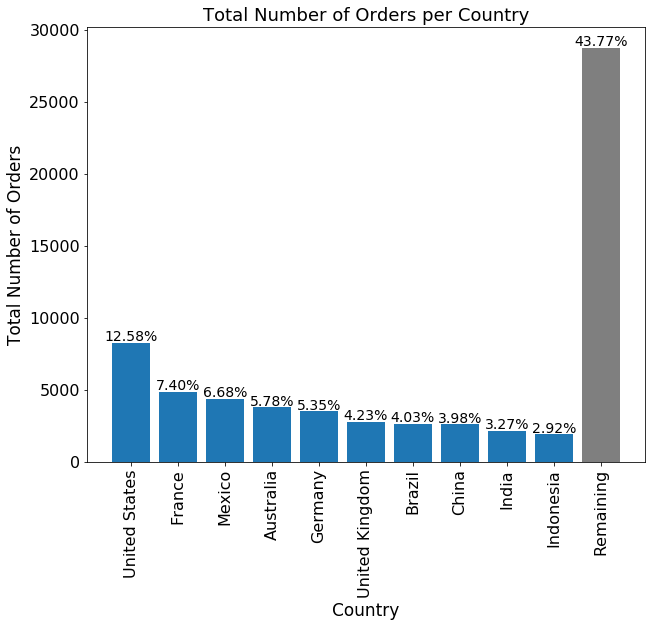

In [380]:
# plotting the top ten countries
plt.figure(figsize=(10, 8))
series_country = df_orders["Order Country"].value_counts()[:10]
nbr_orders = df_orders["Order Country"].value_counts().sum()
ind = range(len(series_country))
plt.bar(ind, series_country.values)
plt.bar(
    len(series_country), 
    df_orders["Order Country"].value_counts().sum() - series_country.values.sum(), 
    color="C7"
)
plt.title("Total Number of Orders per Country")
xtickslabels = [
    "United States", "France", "Mexico", "Australia",
    "Germany", "United Kingdom", "Brazil", "China", 
    "India", "Indonesia", "Remaining"
]
plt.xticks(range(len(series_country)+1), xtickslabels, rotation="vertical")
plt.xlabel("Country")
plt.ylabel("Total Number of Orders")

ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

# Which is the most used shipment method 

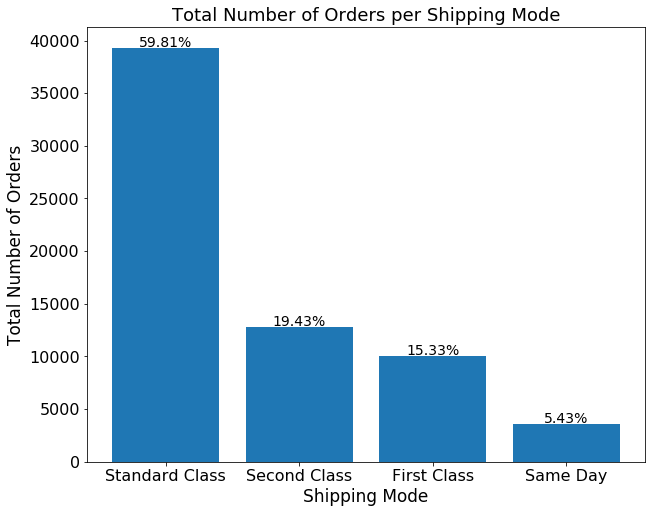

In [99]:
plt.figure(figsize=(10, 8))
series_shipping = df_orders["Shipping Mode"].value_counts()
nbr_orders = series_shipping.sum()
ind = range(len(series_shipping))
plt.bar(ind, series_shipping.values)
plt.title("Total Number of Orders per Shipping Mode")
plt.xticks(ind, series_shipping.index)
plt.xlabel("Shipping Mode")
plt.ylabel("Total Number of Orders")

ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

# Delay between scheduled delivery date and actual delivery date 

Let's first create the feature.

In [191]:
df_orders["Shipment Delay"] = df_orders["Days for shipping (real)"] - df_orders["Days for shipment (scheduled)"]

In [192]:
df_orders.head()

,Customer Country,Shipping Mode,Days for shipping (real),Days for shipment (scheduled),order date (DateOrders),shipping date (DateOrders),Shipment Delay
Order Id,,,,,,,
1,EE. UU.,Standard Class,2,4,2015-01-01 00:00:00,2015-01-03 00:00:00,-2
2,EE. UU.,Standard Class,3,4,2015-01-01 00:21:00,2015-01-04 00:21:00,-1
4,EE. UU.,Standard Class,5,4,2015-01-01 01:03:00,2015-01-06 01:03:00,1
5,Puerto Rico,Standard Class,6,4,2015-01-01 01:24:00,2015-01-07 01:24:00,2
7,EE. UU.,Second Class,3,2,2015-01-01 02:06:00,2015-01-04 02:06:00,1


Plotting the histogram.

In [125]:
df_orders["Shipment Delay"].value_counts()

 1    22120
 0    12267
 2    10461
-2     7910
-1     7877
 4     2564
 3     2553
Name: Shipment Delay, dtype: int64

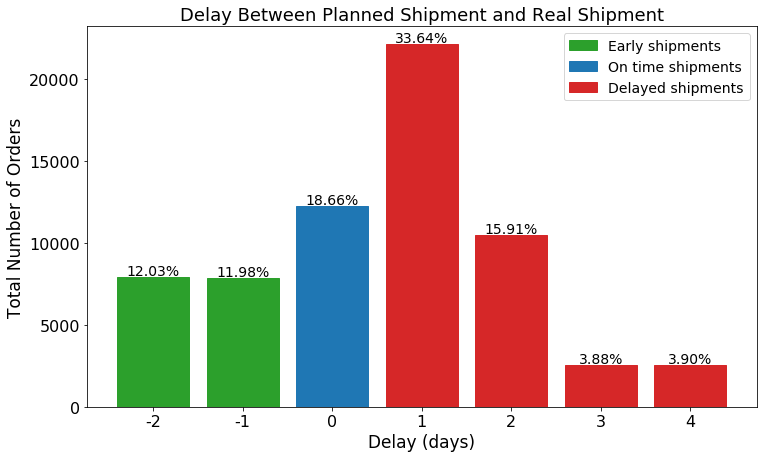

In [219]:
shipment_delays = df_orders["Shipment Delay"].value_counts().sort_index()
ind = range(len(shipment_delays))
barlist = plt.bar(ind, shipment_delays.values)
plt.title("Delay Between Planned Shipment and Real Shipment")
plt.ylabel("Total Number of Orders")
plt.xlabel("Delay (days)")
plt.xticks(ind, shipment_delays.index)
for idx, label in enumerate(shipment_delays.index):
    if label < 0:
        color = "C2"
    elif label > 0:
        color = "C3"
    else:
        color = "C0"
    barlist[idx].set_color(color)
    
# manually set the legend
red_patch = mpatches.Patch(color="C3", label="Delayed shipments")
green_patch = mpatches.Patch(color="C2", label="Early shipments")
blue_patch = mpatches.Patch(color="C0", label="On time shipments")
plt.legend(handles=[green_patch, blue_patch, red_patch])

# percentages
ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

# Days between order date and shipping date 

## Raw number (disregard business days) 

In [200]:
days_between = df_orders["shipping date (DateOrders)"] - df_orders["order date (DateOrders)"]
days_between_totals = days_between.dt.days.value_counts().sort_index()

In [208]:
# dumb workaround to fill 1 index with zero.
days_totals = []
max_days = days_between_totals.index.max()
for i in range(max_days+1):
    try:
        days_totals.append(days_between_totals.loc[i])
    except KeyError:
        days_totals.append(0)

In [209]:
days_totals

[3571, 0, 20554, 10408, 10423, 10336, 10460]

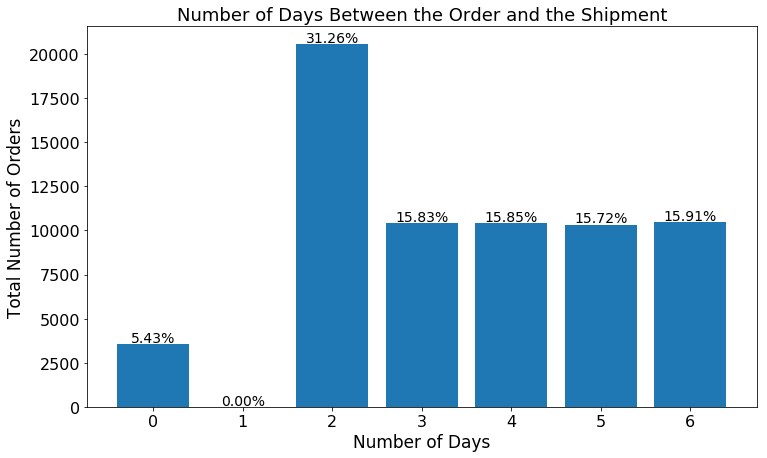

In [215]:
ind = range(len(days_totals))
plt.bar(ind, days_totals)
plt.title("Number of Days Between the Order and the Shipment")
plt.ylabel("Total Number of Orders")
plt.xlabel("Number of Days")
# percentages
ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

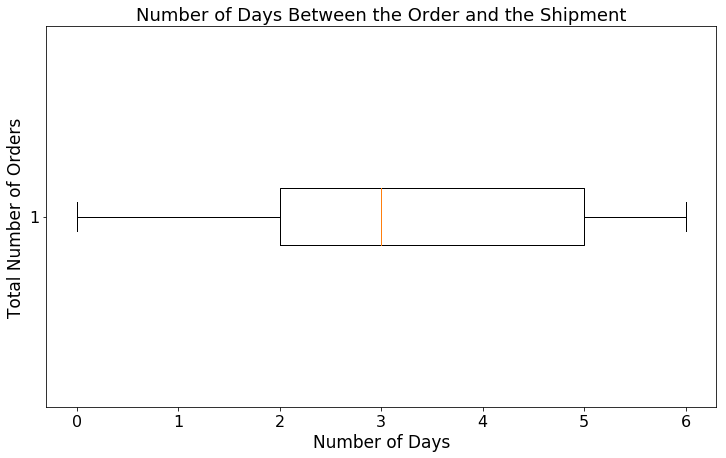

In [290]:
plt.boxplot(days_between.dt.days, vert=False)
plt.title("Number of Days Between the Order and the Shipment")
plt.ylabel("Total Number of Orders")
plt.xlabel("Number of Days");

## Considering business days

In [244]:
enddates = df_orders["shipping date (DateOrders)"].values.astype("datetime64[D]")
begindates = df_orders["order date (DateOrders)"].values.astype("datetime64[D]")
busdaysbetween = np.busday_count(begindates, enddates)

In [250]:
busdays_totals = pd.Series(busdaysbetween).value_counts().sort_index()

In [252]:
busdays_totals

0     5266
1    10116
2    19176
3    13344
4    13365
5     4485
dtype: int64

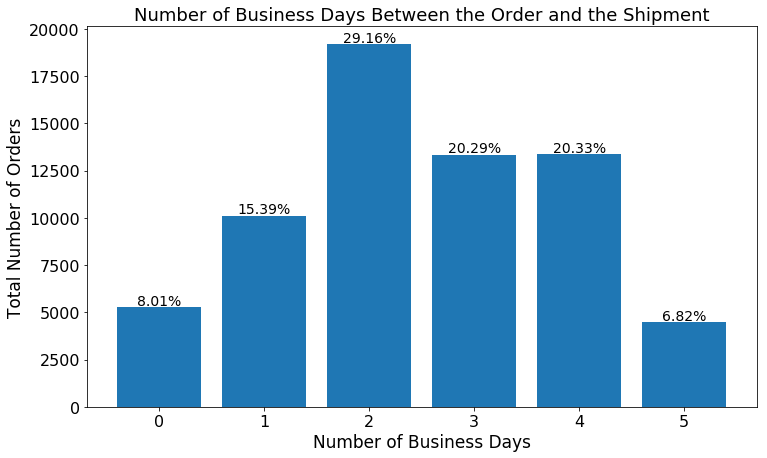

In [253]:
ind = range(len(busdays_totals))
plt.bar(ind, busdays_totals.values)
plt.title("Number of Business Days Between the Order and the Shipment")
plt.ylabel("Total Number of Orders")
plt.xlabel("Number of Business Days")
# percentages
ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

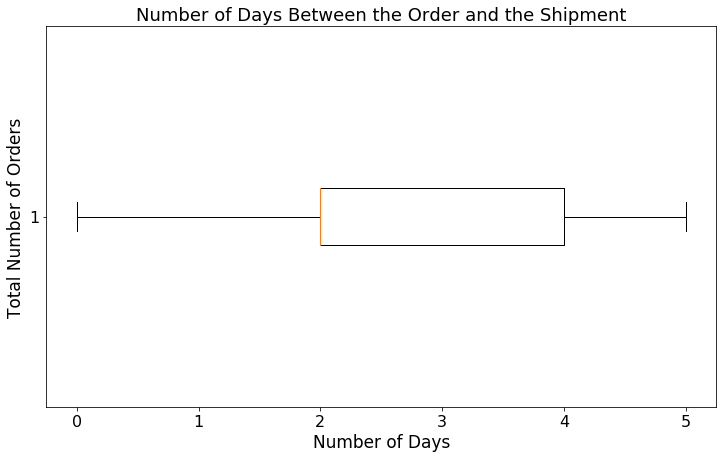

In [291]:
plt.boxplot(busdaysbetween, vert=False)
plt.title("Number of Days Between the Order and the Shipment")
plt.ylabel("Total Number of Orders")
plt.xlabel("Number of Days");

# Aggregation by category 

In [17]:
df[["Category Name", "Sales"]].groupby("Category Name").sum()

,Sales
Category Name,
Accessories,1.336715e+05
As Seen on TV!,2.059794e+04
Baby,1.222956e+04
Baseball & Softball,9.405715e+04
Basketball,2.709933e+04
Books,1.258740e+04
Boxing & MMA,8.520541e+04
CDs,3.059590e+03
Cameras,2.676077e+05


# Delivery status 

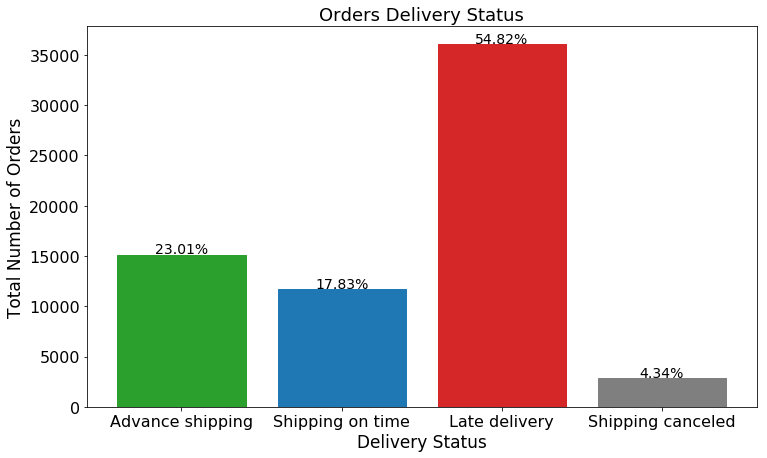

In [277]:
deliveries_status = df_orders["Delivery Status"].value_counts()
index_order = [
    "Advance shipping", "Shipping on time",
    "Late delivery", "Shipping canceled"
]
deliveries_status = deliveries_status.reindex(index_order)
ind = range(len(deliveries_status))
barlist = plt.bar(ind, deliveries_status.values)
plt.title("Orders Delivery Status")
plt.ylabel("Total Number of Orders")
plt.xlabel("Delivery Status")
plt.xticks(ind, deliveries_status.index)
barlist[0].set_color("C2")
barlist[1].set_color("C0")
barlist[2].set_color("C3")
barlist[3].set_color("C7")

# percentages
ax = plt.gca()
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{:.2%}'.format(height/nbr_orders), 
        (p.get_x()+.5*width, p.get_y() + height + 125), 
        ha='center',
        fontsize=14
    );

# Predicting the Order Delivery Status 

Here I select the features to be used in the model based on gut feeling. We begin with some easy features first as a baseline model. We assume that the country and the shipping mode will be enough to distiguish between our three classes: `Advance shipping`, `Shipping on time`, `Late delivery`, and `Shipping canceled`.

In [475]:
df_orders.head()

,Order Id,Customer Country,Shipping Mode,Days for shipping (real),Days for shipment (scheduled),order date (DateOrders),shipping date (DateOrders),Delivery Status,Order Country,Customer Zipcode,Order Item Quantity,Product Price
Order Id,,,,,,,,,,,,
1,1,EE. UU.,Standard Class,2,4,2015-01-01 00:00:00,2015-01-03 00:00:00,Advance shipping,México,28601.0,1,299.980011
2,2,EE. UU.,Standard Class,3,4,2015-01-01 00:21:00,2015-01-04 00:21:00,Advance shipping,Colombia,60625.0,7,379.980011
4,4,EE. UU.,Standard Class,5,4,2015-01-01 01:03:00,2015-01-06 01:03:00,Late delivery,Colombia,78240.0,14,184.960001
5,5,Puerto Rico,Standard Class,6,4,2015-01-01 01:24:00,2015-01-07 01:24:00,Late delivery,Colombia,725.0,10,839.920029
7,7,EE. UU.,Second Class,3,2,2015-01-01 02:06:00,2015-01-04 02:06:00,Late delivery,Brasil,33161.0,7,515.960016


In [534]:
# baseline model features
features = [
    {"name": "Order Country", "one_hot_encoding": True},
    {"name": "Shipping Mode", "one_hot_encoding": True},
    {"name": "Customer Zipcode", "one_hot_encoding": True},
    {"name": "Order City", "one_hot_encoding": True}
]
extracted_features = [e["name"] for e in features]

# split features and target
X = df_orders[extracted_features]
y = df_orders["Delivery Status"]

# one-hot encode categorical features
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X_enc = enc.transform(X).toarray()

# concatenate numerical variables
numericals = np.array(
    df_orders[["Days for shipment (scheduled)", "Order Item Quantity", "Product Price", "Sales per customer"]]
)
X_enc = np.concatenate((X_enc, numericals), axis=1)

In [535]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, random_state=42)

# fit ML classifier to predict the "Delivery Status" via 5-fold cross-validation
clf = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=42)
cv_results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True)

In [536]:
cv_results

{'fit_time': array([33.50368595, 42.54220915, 37.25908303, 32.73883867, 41.19069195]),
 'score_time': array([0.62324905, 0.46437287, 0.57128572, 0.45041728, 0.49849319]),
 'test_score': array([0.54686651, 0.54725179, 0.5468767 , 0.54699554, 0.54829947]),
 'train_score': array([0.55191895, 0.54818295, 0.54789647, 0.55033812, 0.55256511])}

In [537]:
# refit the model in the whole training data
clf = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=42)
clf.fit(X_train, y_train)
print("Train accuracy is:", clf.score(X_train, y_train))
print("Test accuracy is:", clf.score(X_test, y_test))

Train accuracy is: 0.5481270641404484
Test accuracy is: 0.551128010139417
